In [ ]:
# Imports and GPU setup

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib
from IPython import display
from google.colab import drive
from PIL import Image

print(f"Found GPU at: {tf.test.gpu_device_name()}.\nTensorFlow version: {tf.__version__}")

Found GPU at: /device:GPU:0.
TensorFlow version: 2.7.0


In [ ]:
# Helper function for displaying images
    
def show_images(images):
    num_images = len(images)
    fig, cells = plt.subplots(ncols=num_images, nrows=1, figsize=(2 * num_images, 2))
    for cell_num in range(num_images):
        cells[cell_num].matshow(images[cell_num])
        cells[cell_num].axis('off')
    plt.show()

In [ ]:
# A GAN class as an extension of the tf.keras.Model object

class GAN(tf.keras.Model):

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

    def compute_loss(self, reals):
        # Generate a random vector seed and use it with the generator network to generate a fake image
        batch_size = reals.shape[0]
        seed = tf.random.normal([batch_size, 1, 1, self.seed_size])
        fakes = self.gen(seed)

        # Use the discriminator network to obtain labels for both the generated data (x_gen) and the real data (x)
        logits_reals = self.disc(reals)
        logits_fakes = self.disc(fakes)

        # Calculate discriminator loss (loss over real + loss over fake data) and generator loss (over fake data)
        disc_loss = gan_loss(logits_reals, is_real=True) + gan_loss(logits_fakes, is_real=False)
        gen_loss = gan_loss(logits_fakes, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        # Pass x through network, compute losses and gradients
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
def gan_loss(logits, is_real=True):
    # Computes cross entropy between logits and labels
    labels = tf.ones_like(logits) if is_real else tf.zeros_like(logits)
    return tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)

In [ ]:
# These lines enable you to get the images from your own GDrive
# drive.mount('/content/gdrive')
# dataset_url = f"file:///content/gdrive/My Drive/MLDatasets/ADQArt64.tgz"

In [ ]:
# Download and expand images to a local (colab) directory from a .tgz file. 
# Images in the tgz file should be compressed in a single sub-directory

DATABASE_NAME = "ADQArt64"
#DATABASE_NAME = "ADQFaces64" # Note: face images from: cfpw.io"
#DATABASE_NAME = "ADQArtFaces64"

dataset_url = f"http://www.artdonequick.com/downloads/MLDatasets/{DATABASE_NAME}.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname=f"{DATABASE_NAME}", untar=True)
data_dir = pathlib.Path(data_dir)
print(f"{DATABASE_NAME}.tgz downloaded, expanded and images stored locally to: {data_dir}")

# Load images, convert to a tensor and normalise

image_arrays = []
for filename in os.listdir(data_dir):
    try: 
      image = Image.open(os.path.join(data_dir,filename))
      image_arrays.append(np.asarray(image))
    except IOError:
      print(f"bad image: {filename}")

array_of_image_arrays = np.array(image_arrays)
train_images = (tf.convert_to_tensor(array_of_image_arrays, dtype=tf.float32))/255 # Normalising RGB to between 0 and 1
print(f"Shape of training images tensor: {train_images.shape}")

5824512/5808914 [==============================] - 1s 0us/step
ADQArt64.tgz downloaded, expanded and images stored locally to: /root/.keras/datasets/ADQArt64
bad image: ._ADQ_64_0.jpg
Shape of training images tensor: (3000, 64, 64, 3)


In [ ]:
# Set up some parameters

image_size = 64
batch_size = 500
n_channels = 3
n_training_batches = int(len(train_images)/batch_size)
input_shape = (image_size, image_size, n_channels)
print(f"Batch size: {batch_size}\nNumber of training batches: {n_training_batches}")

Batch size: 500
Number of training batches: 6


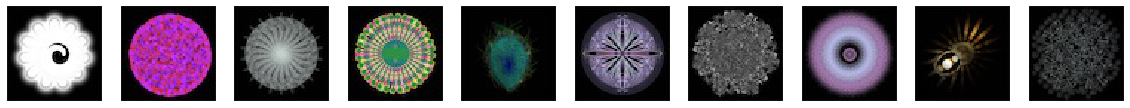

In [ ]:
# Set up the training and test datasets and show some images from the training set

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(batch_size)
show_images(train_images[0:10])

In [ ]:
# Set up the generator network structure with 6 layers:
# Input, Dense, Reshape, 3 x ConvlutionTranspose

stride = 2 # factor to scale image up by in each convolution layer
reshape_layer_size = image_size//(stride * 2)
seed_size = image_size * (2 ** 1) * n_channels
num_dense_units = (reshape_layer_size ** 2) * seed_size

generator = [
    tf.keras.layers.Dense(units=num_dense_units, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(reshape_layer_size, reshape_layer_size, seed_size)),
    tf.keras.layers.Conv2DTranspose(filters=seed_size, kernel_size=3, strides=(stride, stride), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=seed_size/2, kernel_size=3, strides=(stride, stride), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=n_channels, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid")
]

# Build the network and show a summary
gen = tf.keras.Sequential(generator)
gen.build([train_images.shape[0], 1, 1, seed_size])
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (3000, 1, 1, 98304)       37847040  
                                                                 
 reshape (Reshape)           (3000, 16, 16, 384)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (3000, 32, 32, 384)      1327488   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (3000, 64, 64, 192)      663744    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (3000, 64, 64, 3)        5187      
 ranspose)                                                       
                                                        

In [ ]:
# Set up the discriminator network structure with 5 layers:
# Input, Convolution x 2, Flatten, Dense

discriminator = [
    tf.keras.layers.InputLayer(input_shape),
    tf.keras.layers.Conv2D(filters=seed_size/2, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Conv2D(filters=seed_size, kernel_size=3, strides=(2, 2), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None)
]

# Build the network and show a summary
disc = tf.keras.Sequential(discriminator)
disc.build(input_shape)
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 192)       5376      
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 384)       663936    
                                                                 
 flatten (Flatten)           (None, 86400)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 86401     
                                                                 
Total params: 755,713
Trainable params: 755,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Re-load pre-trained networks if needed

# gen = tf.keras.models.load_model(generator_file_path_pre)
# disc = tf.keras.models.load_model(discriminator_file_path_pre)


 Epoch 0


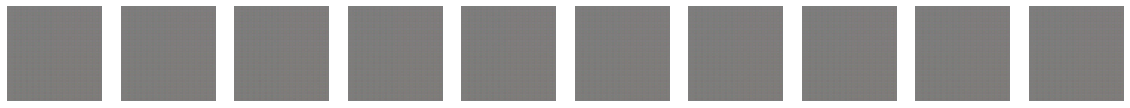


 Epoch 1


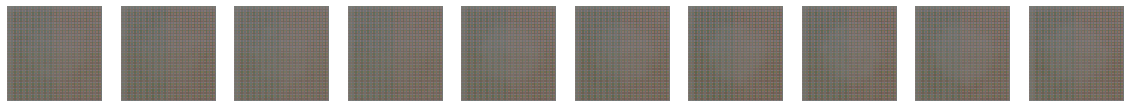


 Epoch 2


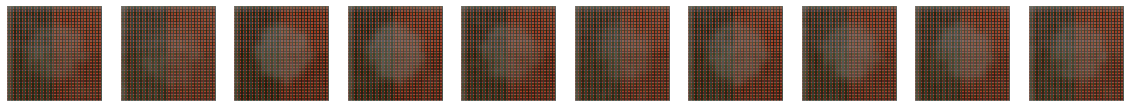


 Epoch 3


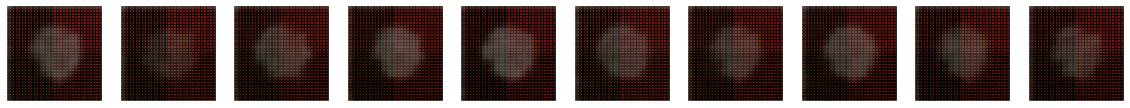


 Epoch 4


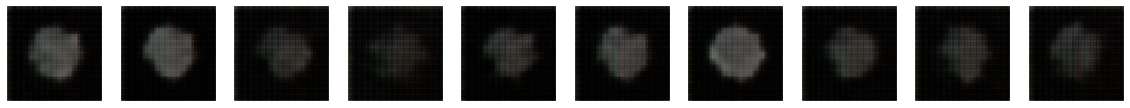

KeyboardInterrupt: ignored

In [ ]:
# Set up the optimisers and the GAN model, and train it
# Note: use display.clear_output() to clear the output each time

gen_optimizer = tf.keras.optimizers.Adam(0.0001, 0.4) # defaults were: learning rate=0.001 and beta=0.5
disc_optimizer = tf.keras.optimizers.RMSprop(0.0001) # default was: learning rate=0.001
model = GAN(gen=gen, disc=disc, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer, seed_size=seed_size)

for epoch in range(500):
    for batch, train_x in zip(range(n_training_batches), train_dataset):
        model.train(train_x)
    
    # Show some example generated images for the network in its current state
    print(f"\n Epoch {epoch}")
    generated_images = model.gen(tf.random.normal(shape=(10, seed_size)))
    show_images(generated_images)

In [ ]:
# Save trained models
drive.mount('/content/gdrive')
output_dir = f"/content/gdrive/My Drive/TrainedModels/{DATABASE_NAME}_303epochs"
gen.save(f"{output_dir}/gen.tf", save_format='tf')
disc.save(f"{output_dir}/disc.tf", save_format='tf')